In [2]:
from tqdm import tqdm, trange
from copy import deepcopy

import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import scipy as sp
import time
import sys
import importlib
import os
import hashlib
import subprocess
import gc

from IPython import display
from IPython.display import clear_output
import copy
from copy import deepcopy
# from sklearn.metrics import roc_auc_score, roc_curve

# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from torch.utils.data import Dataset

# from captum.attr import IntegratedGradients
# from captum.attr import LayerConductance
# from captum.attr import NeuronConductance

try:
    import cPickle as pickle
except:
    import pickle
    
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

code_folder1="/home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09_filtered_subset/"
code_folder2=f"{code_folder1}/prediction_step_0/"

import sys
sys.path.append(code_folder1)
sys.path.append(code_folder2)


energy_folder="/home/energy/ykhalak/ML_dG/pde2_dG/retrospective_active_learning_in_6EZF/"
energy_folder_workstation="/netmount/energy/ykhalak/ML_dG/pde2_dG/retrospective_active_learning_in_6EZF/"
all_ligs_db_file_energy=f"{energy_folder_workstation}/full_ligs.pickle"


all_ligs_db_file_old="/home/ykhalak/Projects/ML_dG/pde2_dG/how_do_ligs_fit_in_pocket/adaptive_learning_test_from_morphed_structs/../processed_ligs_w_morphing_sim_annealing_only_sucessfull.pickle"
experiment_folder="/home/ykhalak/Projects/ML_dG/pde2_dG/retrospective_active_learning_in_6EZF/"
all_ligs_db_file=f"{experiment_folder}/full_ligs.pickle"

datafolder=f"{experiment_folder}/cached_reprs"

# settings_folder=f"{experiment_folder}/combined_repr_search_with_repeats_and_mparam_scan/settings/"
# os.makedirs(settings_folder, exist_ok=True)

sys.path.append(experiment_folder)

Bohr2Ang=0.529177249
RT=0.001985875*300 #kcal/mol


# Import training code

In [3]:
if 'custom_dataset_modular_with_binning_6EZF' in sys.modules:
    importlib.reload(sys.modules['custom_dataset_modular_with_binning_6EZF'])
else:
    import custom_dataset_modular_with_binning_6EZF
from custom_dataset_modular_with_binning_6EZF import dataBlocks, CustomMolModularDataset

if 'owl_trainer_w_params_general_with_ensemble_summary_model_6EZF' in sys.modules:
    importlib.reload(sys.modules['owl_trainer_w_params_general_with_ensemble_summary_model_6EZF'])
else:
    import owl_trainer_w_params_general_with_ensemble_summary_model_6EZF
from owl_trainer_w_params_general_with_ensemble_summary_model_6EZF import *

# Define representation blocks

In [4]:
flags_2D=[dataBlocks.MACCS, dataBlocks.Descriptors, dataBlocks.Graph_desc, dataBlocks.BCUT2D]
flags_3D=[dataBlocks.EState_FP, dataBlocks.Pharmacophore_feature_map,
          dataBlocks.MOE, dataBlocks.MQN, dataBlocks.GETAWAY, dataBlocks.AUTOCORR2D,
          dataBlocks.AUTOCORR3D, dataBlocks.WHIM, dataBlocks.RDF,
          dataBlocks.USR, dataBlocks.USRCUT, dataBlocks.PEOE_VSA, dataBlocks.SMR_VSA,
          dataBlocks.SlogP_VSA, dataBlocks.MORSE]

flags_2D_3D=flags_2D+flags_3D

# load active learner code

In [5]:
#! ln -s /home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09_filtered_subset/prediction_step_0/utils.py $experiment_folder/utils.py

if 'active_learner_6EZF' in sys.modules:
    importlib.reload(sys.modules['active_learner_6EZF'])
else:
    import active_learner_6EZF
from active_learner_6EZF import *

# set up learner_settings files

In [6]:
get_represetations()[1]

['2D_3D',
 'PLEC_filtered',
 'MDenerg',
 'MDenerg_long_cut',
 'MDenerg_binned',
 'MDenerg_long_cut_binned',
 'atom_hot',
 'atom_hot_surf']

In [6]:
normalize_x=True
shuffle_seed=12345678

#n_Epochs=2000
#hl_w=300
#hl_depth=2

n_Epochs=200
hl_w=20
hl_depth=1

init_learning_rate=5e-3
learning_rate_decay=10000 #order of magnitude in this many epochs
weight_decay=1e-3

normalize_x=True
X_filter=None
impfilt=None

weighted=True
use_dropout=True
shiftY=True

redo=False

possible_reprs, possible_repr_names = get_represetations()

n_picks_per_step=100

sele_rule=SelectionRule.greedy
run_name_prefixes=[f"step_size_{n_picks_per_step}_sele_rule_greedy_repr_{s}" for s in possible_repr_names]

repr_method_sfiles=[]

starting_method=StartingSelectionMethod.weighted_by_2D_repr

learner_settings_folder=f"{experiment_folder}/repr_comparison/AL_settings"
os.makedirs(learner_settings_folder, exist_ok=True)

hl_w='auto'
hl_depth='auto'
n_Epochs='auto'

counter=0
unfinished=[]

hashes_per_repr_method=[]

repeats_fnames=[]
repeats_logfns=[]
for repr_id in range(len(possible_reprs)):
    this_repr_method_sfiles=[]
    this_repr_method_hashes=[]
    fixed_repr = (possible_reprs[repr_id], possible_repr_names[repr_id])
    for r in range(5):
        run_name=f"{run_name_prefixes[repr_id]}_repeat_{r}"
        starting_ligs_seed=123456+r
        learner_settings=[
            normalize_x, shuffle_seed, n_Epochs, init_learning_rate, learning_rate_decay, weight_decay,
            impfilt, X_filter, weighted, shiftY, use_dropout, sele_rule, starting_method, hl_w, hl_depth,
            starting_ligs_seed,n_picks_per_step,fixed_repr,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,run_name
        ]

        sha = hashlib.sha256()
        sha.update(pickle.dumps(learner_settings))
        settings_hash=sha.hexdigest()[:6]
        this_repr_method_hashes.append(settings_hash)

        settings_fname=f"{learner_settings_folder}/learner_settings_{run_name}_{settings_hash}.pickle"
        if(os.path.exists(settings_fname)):
            with open(settings_fname, 'rb') as f:
                settings_loaded, learner_metrics = pickle.load(f)
                if(learner_metrics is not None and not redo):
                    if(len(learner_metrics.top10_found)<7):
                        print(f"{settings_fname} has started but is not finished.")
                        unfinished.append(counter)
                    else:
                        print(f"{settings_fname} has finished.")
                else:
                    print(f"{settings_fname} exists but is not trained yet.")
                    unfinished.append(counter)
        else:
            #pickle.dump( (learner_settings, None), open( settings_fname, "wb" ) )
            unfinished.append(counter)
#             pass


        repeats_fnames.append(settings_fname)

        os.makedirs(f"{learner_settings_folder}/run_{settings_hash}/", exist_ok=True)
        repeats_logfns.append(f"{learner_settings_folder}/run_{settings_hash}/run_{settings_hash}.log")
        this_repr_method_sfiles.append(settings_fname)
        print(settings_fname)
        counter+=1
    repr_method_sfiles.append(this_repr_method_sfiles)
    hashes_per_repr_method.append(this_repr_method_hashes)

/home/ykhalak/Projects/ML_dG/pde2_dG/retrospective_active_learning_in_6EZF//repr_comparison/AL_settings/learner_settings_step_size_100_sele_rule_greedy_repr_2D_3D_repeat_0_fd5053.pickle has finished.
/home/ykhalak/Projects/ML_dG/pde2_dG/retrospective_active_learning_in_6EZF//repr_comparison/AL_settings/learner_settings_step_size_100_sele_rule_greedy_repr_2D_3D_repeat_0_fd5053.pickle
/home/ykhalak/Projects/ML_dG/pde2_dG/retrospective_active_learning_in_6EZF//repr_comparison/AL_settings/learner_settings_step_size_100_sele_rule_greedy_repr_2D_3D_repeat_1_ba88f2.pickle has finished.
/home/ykhalak/Projects/ML_dG/pde2_dG/retrospective_active_learning_in_6EZF//repr_comparison/AL_settings/learner_settings_step_size_100_sele_rule_greedy_repr_2D_3D_repeat_1_ba88f2.pickle
/home/ykhalak/Projects/ML_dG/pde2_dG/retrospective_active_learning_in_6EZF//repr_comparison/AL_settings/learner_settings_step_size_100_sele_rule_greedy_repr_2D_3D_repeat_2_d5ab9f.pickle has finished.
/home/ykhalak/Projects/ML_dG

In [7]:
for this_repr_method_sfiles in repr_method_sfiles:
    print(len(this_repr_method_sfiles))

5
5
5
5
5
5
5
5


In [8]:
print(unfinished)
for i in unfinished:
    print(repeats_fnames[i])

[]


# Launch repeats of active learnerning with different seeds

In [24]:
if 'custom_dataset_modular_with_binning_6EZF' in sys.modules:
    importlib.reload(sys.modules['custom_dataset_modular_with_binning_6EZF'])
else:
    import custom_dataset_modular_with_binning_6EZF
from custom_dataset_modular_with_binning_6EZF import dataBlocks, CustomMolModularDataset

if 'NNs' in sys.modules:
    importlib.reload(sys.modules['NNs'])
else:
    import NNs
from NNs import *

if 'owl_trainer_w_params_general_with_ensemble_summary_model_6EZF' in sys.modules:
    importlib.reload(sys.modules['owl_trainer_w_params_general_with_ensemble_summary_model_6EZF'])
else:
    import owl_trainer_w_params_general_with_ensemble_summary_model_6EZF
from owl_trainer_w_params_general_with_ensemble_summary_model_6EZF import *

if 'active_learner_6EZF' in sys.modules:
    importlib.reload(sys.modules['active_learner_6EZF'])
else:
    import active_learner_6EZF
from active_learner_6EZF import *

In [17]:
class redirect_output(object):
    """context manager for reditrecting stdout/err to files"""


    def __init__(self, stdout='', stderr=''):
        self.stdout = stdout
        self.stderr = stderr

    def __enter__(self):
        self.sys_stdout = sys.stdout
        self.sys_stderr = sys.stderr

        if self.stdout:
            sys.stdout = open(self.stdout, 'w')
        if self.stderr:
            if self.stderr == self.stdout:
                sys.stderr = sys.stdout
            else:
                sys.stderr = open(self.stderr, 'w')

    def __exit__(self, exc_type, exc_value, traceback):
        sys.stdout = self.sys_stdout
        sys.stderr = self.sys_stderr

In [25]:
from multiprocessing import Process, Queue, Pool, TimeoutError, Lock
import dill

global mp_lock;
mp_lock = Lock()

def run_dill_encoded(payload):
    fun, args = dill.loads(payload)
    return fun(*args)
# def my_pool_apply_async(pool, fun, args):
#     payload = dill.dumps((fun, args))
#     return pool.apply_async(run_dill_encoded, (payload,))
def my_pool_map(pool, fun, args_list):
    payloads = [dill.dumps((fun, [arg])) for arg in args_list]
    return pool.map(run_dill_encoded, payloads)

def run_AL_single(A):
    settings_fname, logfn=A
    with redirect_output(logfn):
        #print(settings_fname, logfn)
        #AL_Trainer(settings_fname, all_ligs_db_file, redo=False, verbose=True)
        all_ligs_db_file_cluster=f"{energy_folder}/full_ligs.pickle"
        AL_Trainer(settings_fname, all_ligs_db_file_cluster, redo=True, verbose=True,
                   use_moa=True,
                   experiment_folder_override=f"{experiment_folder}/repr_comparison/")



args=list(zip(repeats_fnames,repeats_logfns))
#args=list(zip(repeats_fnames[15:],repeats_logfns[15:]))
args=[args[i] for i in unfinished]
with Pool(processes=len(args), initargs=(mp_lock,)) as pool:
    my_pool_map(pool, run_AL_single, args)

In [ ]:
# for A in args[10:]:
#     print(A[0])
#     run_AL_single(A)

# Plot AL metrics

In [39]:
# load the repeats of the protocol
AL_repeat_metrics=[]
for fn in repr_method_sfiles[0]:
    with open(fn, 'rb') as f:
        learner_settings, learner_metrics = pickle.load(f)
        AL_repeat_metrics.append(learner_metrics)
        
mgroups=["selected", "unmeasured", "top10", "top50", "top244"]
        
run_mean_hist=LearningHistory()
for m in run_mean_hist.metrics_auto:
    atrname=m+'_'+'XVal'
    c=np.array([getattr(AL_repeat_metrics[i], atrname) for i in range(len(AL_repeat_metrics))])
#     print(c)
    setattr(run_mean_hist, atrname, np.mean(c, axis=0))
    setattr(run_mean_hist, atrname+"_err", np.std(c, axis=0)/np.sqrt(len(AL_repeat_metrics)))
    
#     raise()
    
    for d in mgroups:
        for m in run_mean_hist.metrics:
            atrname=m+'_'+d
            c=np.array([getattr(AL_repeat_metrics[i], atrname) for i in range(len(AL_repeat_metrics))])
            setattr(run_mean_hist, atrname, np.mean(c, axis=0))
            setattr(run_mean_hist, atrname+"_err", np.std(c, axis=0)/np.sqrt(len(AL_repeat_metrics)))
        
mgroups=["top10_found", "top50_found", "top244_found"]
for atrname in mgroups:
    c=np.array([getattr(AL_repeat_metrics[i], atrname) for i in range(len(AL_repeat_metrics))])
    setattr(run_mean_hist, atrname, np.mean(c, axis=0))
    setattr(run_mean_hist, atrname+"_err", np.std(c, axis=0)/np.sqrt(len(AL_repeat_metrics)))

/home/ykhalak/soft/anaconda3/envs/python3_ML_v2/lib/python3.6/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/ykhalak/soft/anaconda3/envs/python3_ML_v2/lib/python3.6/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/ykhalak/soft/anaconda3/envs/python3_ML_v2/lib/python3.6/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


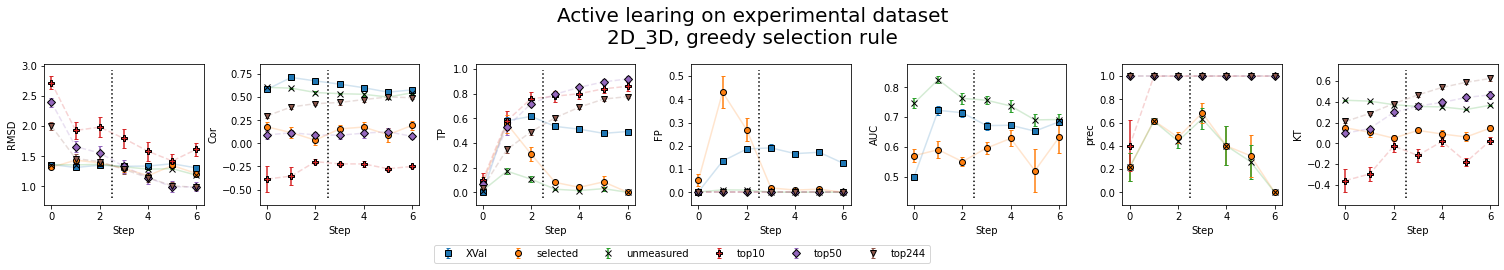

In [40]:
pgroups=["XVal", "selected", "unmeasured", "top10", "top50", "top244"]

markers=['s','o','x','P','D','v','^','<','>',]
alpha=0.2

x=np.arange(len(run_mean_hist.RMSD_XVal))

n_sub_plots=len(run_mean_hist.metrics)
fig, axs = plt.subplots(1, n_sub_plots, figsize=[n_sub_plots*3, 1*3+0.5], facecolor='w')
for sp in range(n_sub_plots):
    plt.sca(axs[sp])
    #plt.ylim(0,6.0)
    #plt.xlabel("# known ligands")
    plt.xlabel("Step")
    plt.ylabel(run_mean_hist.metrics[sp])
        
    for cnum in range(len(pgroups)):
        lw=1.5
        lbl=pgroups[cnum]
        ls="solid"
        if("top" in lbl):
            ls="dashed"
        atrname=run_mean_hist.metrics[sp]+'_'+lbl
        
        if not hasattr(run_mean_hist, atrname+"_err"):
            continue;
        y_avg=getattr(run_mean_hist, atrname)
        y_sem=getattr(run_mean_hist, atrname+"_err")
        if(len(y_avg)!=len(x)):
            continue;
        plt.plot(x, y_avg, linestyle=ls, c=f"C{cnum}", linewidth=lw, alpha=alpha)
        plt.errorbar(x, y_avg, yerr=y_sem, c=f"C{cnum}", marker=markers[cnum], capsize=2, linestyle="None", label=lbl, markeredgecolor='k')
        
    plt.vlines(2.5, plt.gca().get_ylim()[0], plt.gca().get_ylim()[1], colors="black", linestyles='dotted')
        
plt.suptitle("Active learing on experimental dataset\n2D_3D, greedy selection rule", size=20)
plt.tight_layout(rect=[0, 0.03, 1, 1.01])

plt.sca(axs[0])
plt.legend(loc='lower center', bbox_to_anchor=(4, -0.45), ncol=len(pgroups))
plt.show()

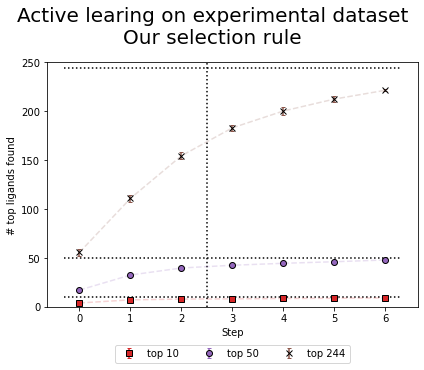

In [41]:
pgroups=["top10_found", "top50_found", "top244_found"]
labels=["top 10", "top 50", "top 244"]

markers=['s','o','x','P','D','v','^','<','>',]
alpha=0.2

x=np.arange(len(run_mean_hist.RMSD_XVal))

plt.figure(figsize=(6,5), facecolor='w')

plt.xlabel("Step")
plt.ylabel("# top ligands found")
    
for cnum in range(len(pgroups)):
    lbl=labels[cnum]#pgroups[cnum][:-6]
    atrname=pgroups[cnum]
    y_avg=getattr(run_mean_hist, atrname)
    y_sem=getattr(run_mean_hist, atrname+"_err")
    plt.plot(x, y_avg, linestyle=ls, c=f"C{cnum+3}", linewidth=lw, alpha=alpha)
    plt.errorbar(x, y_avg, yerr=y_sem, c=f"C{cnum+3}", marker=markers[cnum], capsize=2, linestyle="None", label=lbl, markeredgecolor='k')

xlim=plt.gca().get_xlim()
plt.hlines(10, xlim[0], xlim[1], colors="black", linestyles='dotted')
plt.hlines(50, xlim[0], xlim[1], colors="black", linestyles='dotted')
plt.hlines(244, xlim[0], xlim[1], colors="black", linestyles='dotted')

plt.vlines(2.5, plt.gca().get_ylim()[0], plt.gca().get_ylim()[1], colors="black", linestyles='dotted')
plt.gca().set_ylim((0,250))
        
plt.suptitle("Active learing on experimental dataset\nOur selection rule", size=20)
plt.tight_layout(rect=[0, 0.03, 1, 1.01])

plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.25), ncol=3)
plt.show()

# representation comparison plots

### load ligand dGs

In [9]:
with open(all_ligs_db_file, 'rb') as f:
    ligs = pickle.load(f)
    
lig_dGs=np.zeros(len(ligs))
for i,lig in enumerate(ligs):
    lig_dGs[i]=float(lig.GetProp('dG'))
print(lig_dGs)

sorted_lig_ids_by_expt_dG=np.argsort(lig_dGs)
print(sorted_lig_ids_by_expt_dG)
    
del ligs
_=gc.collect()

[-13.38870799 -13.30640036 -13.29268242 ...  -5.48717541  -5.48717541
  -5.07563725]
[   0    1    2 ... 2327 2337 2350]


### load predictions for each repeat and sele methos

In [12]:
good_repr_ids=[i for i in range(len(possible_repr_names)) if not "binned" in possible_repr_names[i]]
repr_method_names=[possible_repr_names[i] for i in good_repr_ids]
print(repr_method_names)
print(hashes_per_repr_method)
sele=0 # greedy

P_per_repr=[]
P_err_per_repr=[]
for repr in range(len(hashes_per_repr_method)):
    hashes=hashes_per_repr_method[repr]

    P_per_rep=[]
    P_err_per_rep=[]
    for rep in range(len(hashes)):
        P_per_step_temp=[]
        P_err_per_step_temp=[]
        if(sele==1): # narrowing only
            repres_2D_3D_region=[3,7]
            for step in range(0,repres_2D_3D_region[0]):
                cur_settings_folder=f"/home/ykhalak/Projects/ML_dG/pde2_dG/retrospective_active_learning_in_6EZF/repr_comparison/AL_settings/run_{hashes[rep]}/step_{step}/settings/"

                sfiles = next(os.walk(cur_settings_folder), (None, None, []))[2]  # [] if no file
                #sfiles=[f for f in sfiles if (f[0]!='.' and "2D_3D_repeat" in f)] # skip hidden files like .directory and only read 2D_3D
                sfiles=[f for f in sfiles if (f[0]!='.')] # skip hidden files like .directory
                for fn in sfiles:
                    settings_fname=cur_settings_folder+"/"+fn
                    metrics=None
                    with open(settings_fname, 'rb') as f:
                        try:
                            settings_loaded, metrics = pickle.load(f)
                        except Exception as e:
                            print(f"problem with {fn}")
                            raise(e)

                    if(metrics is not None):
                        key=f"{settings_loaded[1]}_hlw{settings_loaded[5]}_hld{settings_loaded[6]}"
                        P_per_step_temp.append(metrics.best_pred[0])
                        P_err_per_step_temp.append(metrics.best_pred[1])
                        
#                         P_per_step_temp.append(metrics.summary_model_best_pred)
#                         P_err_per_step_temp.append(metrics.best_pred[1])

        else:
            repres_2D_3D_region=(0,7)

        for step in range(repres_2D_3D_region[0], repres_2D_3D_region[1]):
            cur_settings_folder=f"/home/ykhalak/Projects/ML_dG/pde2_dG/retrospective_active_learning_in_6EZF/repr_comparison/AL_settings/run_{hashes[rep]}/step_{step}/settings/"
            cur_step_P=[]

            sfiles = next(os.walk(cur_settings_folder), (None, None, []))[2]  # [] if no file
            #sfiles=[f for f in sfiles if (f[0]!='.' and "2D_3D_repeat" in f)] # skip hidden files like .directory and only read 2D_3D
            sfiles=[f for f in sfiles if (f[0]!='.')] # skip hidden files like .directory
            for fn in sfiles:
                settings_fname=cur_settings_folder+"/"+fn
                metrics=None
                with open(settings_fname, 'rb') as f:
                    try:
                        settings_loaded, metrics = pickle.load(f)
                    except Exception as e:
                        print(f"problem with {fn}")
                        raise(e)

                if(metrics is not None):
                    cur_step_P.append(metrics.best_pred[0])
#                     cur_step_P.append(metrics.summary_model_best_pred)
#                     print(cur_step_P)

            #print("sele", sele, "rep", rep, "step", step, len(cur_step_P), len(P_per_step_temp))
            cur_step_P_err=np.std(np.array(cur_step_P), axis=0)
            cur_step_P=np.mean(np.array(cur_step_P), axis=0)
            P_per_step_temp.append(cur_step_P)
            P_err_per_step_temp.append(cur_step_P_err)

        P_per_step_temp=np.array(P_per_step_temp)
        P_err_per_step_temp=np.array(P_err_per_step_temp)
        print("sele", sele, "rep", rep, P_per_step_temp.shape,  P_err_per_step_temp.shape, hashes[rep])
        #print(rep, P_per_step_temp[3,:5])
        P_per_rep.append(P_per_step_temp)
        P_err_per_rep.append(P_err_per_step_temp)
        
        
    #raise()
    P_per_repr.append(P_per_rep)
    P_err_per_repr.append(P_err_per_rep)

['2D_3D', 'PLEC_filtered', 'MDenerg', 'MDenerg_long_cut', 'atom_hot', 'atom_hot_surf']
[['fd5053', 'ba88f2', 'd5ab9f', '82067d', '946370'], ['cd87fe', '3add37', '03bbd1', '912c39', 'd5f698'], ['efaa8d', '1ba5e3', '72a970', '4ae55f', 'acd6ca'], ['f13448', 'cbcf04', 'db9ce4', 'e80ef8', '6a7960'], ['011575', 'a70822', '300d5d', 'affbf5', '1ea314'], ['b5bc5b', '69756f', '28e956', '111080', '098156'], ['819ea7', '02556e', 'f53574', '442e90', '18d2ea'], ['a91e8f', '0fe635', 'a0b0c4', 'dd34e5', '3c3058']]
sele 0 rep 0 (7, 2351) (7, 2351) fd5053
sele 0 rep 1 (7, 2351) (7, 2351) ba88f2
sele 0 rep 2 (7, 2351) (7, 2351) d5ab9f
sele 0 rep 3 (7, 2351) (7, 2351) 82067d
sele 0 rep 4 (7, 2351) (7, 2351) 946370
sele 0 rep 0 (7, 2351) (7, 2351) cd87fe
sele 0 rep 1 (7, 2351) (7, 2351) 3add37
sele 0 rep 2 (7, 2351) (7, 2351) 03bbd1
sele 0 rep 3 (7, 2351) (7, 2351) 912c39
sele 0 rep 4 (7, 2351) (7, 2351) d5f698
sele 0 rep 0 (7, 2351) (7, 2351) efaa8d
sele 0 rep 1 (7, 2351) (7, 2351) 1ba5e3
sele 0 rep 2 (7,

### Load metrics

In [13]:
# load the repeats of the protocol

#ignore the binned ones
good_repr_ids=[i for i in range(len(possible_repr_names)) if not "binned" in possible_repr_names[i]]
repr_method_names=[possible_repr_names[i] for i in good_repr_ids]
run_mean_hist_by_repr_method=[]
for sid in range(len([repr_method_sfiles[i] for i in good_repr_ids])):
    
    AL_repeat_metrics=[]
    for fn in repr_method_sfiles[sid]:
        with open(fn, 'rb') as f:
            learner_settings, learner_metrics = pickle.load(f)
            AL_repeat_metrics.append(learner_metrics)

    mgroups=["selected", "unmeasured", "top10", "top50", "top244"]

    run_mean_hist=LearningHistory()
    for m in run_mean_hist.metrics_auto:
        atrname=m+'_'+'XVal'
        c=np.array([getattr(AL_repeat_metrics[i], atrname) for i in range(len(AL_repeat_metrics))])
    #     print(c)
        setattr(run_mean_hist, atrname, np.mean(c, axis=0))
        setattr(run_mean_hist, atrname+"_err", np.std(c, axis=0)/np.sqrt(len(AL_repeat_metrics)))

    #     raise()

        for d in mgroups:
            for m in run_mean_hist.metrics:
                atrname=m+'_'+d
                c=np.array([getattr(AL_repeat_metrics[i], atrname) for i in range(len(AL_repeat_metrics))])
                setattr(run_mean_hist, atrname, np.mean(c, axis=0))
                setattr(run_mean_hist, atrname+"_err", np.std(c, axis=0)/np.sqrt(len(AL_repeat_metrics)))
                    
    num_known_ligs_by_repeat=[]
    for rep in range(len(AL_repeat_metrics)):
        num_known_ligs=[len(AL_repeat_metrics[rep].step_lig_ids[0])]
        for step in range(1,len(AL_repeat_metrics[rep].step_lig_ids)-1):
            num_known_ligs.append(num_known_ligs[-1]+len(AL_repeat_metrics[rep].step_lig_ids[step]))
        num_known_ligs_by_repeat.append(num_known_ligs)
    num_known_ligs_by_repeat=np.array(num_known_ligs_by_repeat)
    run_mean_hist.num_known_ligs_at_step=num_known_ligs_by_repeat.mean(axis=0)
    print(f"{repr_method_names[sid]:20s}", run_mean_hist.num_known_ligs_at_step)           

    mgroups=["top10_found", "top50_found", "top244_found"]
    for atrname in mgroups:
        c=np.array([getattr(AL_repeat_metrics[i], atrname) for i in range(len(AL_repeat_metrics))])
        setattr(run_mean_hist, atrname, np.mean(c, axis=0))
        setattr(run_mean_hist, atrname+"_err", np.std(c, axis=0)/np.sqrt(len(AL_repeat_metrics)))
        
        
    top_to_look_for=[10,50,244]
    for t in top_to_look_for:
        atrname=f"top{t}_correctly_predicted"
        correctly_prediced=np.zeros((len(AL_repeat_metrics), len(P_per_repr[sid][0]))) # repeats, iter
        for repeat in range(len(AL_repeat_metrics)):
            P_hist=P_per_repr[sid][repeat]
#             print(P_per_repr[sid][repeat].shape)
            for it in range(P_hist.shape[0]):
                P=P_hist[it,:]
                sorted_lig_ids_by_P=np.argsort(P)
                topX_P=sorted_lig_ids_by_P[:t]
                topX_Expt=sorted_lig_ids_by_expt_dG[:t]
                common=np.intersect1d(topX_P, topX_Expt)
                correctly_prediced[repeat, it]=len(common)
                
        setattr(run_mean_hist, atrname, np.mean(correctly_prediced, axis=0))
        setattr(run_mean_hist, atrname+"_err", np.std(correctly_prediced, axis=0)/np.sqrt(len(AL_repeat_metrics)))
        
    run_mean_hist_by_repr_method.append(run_mean_hist)

2D_3D                [100. 200. 300. 400. 500. 600. 700.]
PLEC_filtered        [100. 200. 300. 400. 500. 600. 700.]
MDenerg              [100. 200. 300. 400. 500. 600. 700.]
MDenerg_long_cut     [100. 200. 300. 400. 500. 600. 700.]
atom_hot             [100. 200. 300. 400. 500. 600. 700.]
atom_hot_surf        [100. 200. 300. 400. 500. 600. 700.]


In [14]:
print(repr_method_names)

['2D_3D', 'PLEC_filtered', 'MDenerg', 'MDenerg_long_cut', 'atom_hot', 'atom_hot_surf']


In [15]:
repr_method_names_fixed=[
    '2D_3D',
    'PLEC',
    'MDenerg',
    'MDenerg_LR',
    'atom_hot',
    'atom_hot_surf'
]

## Top X ligands

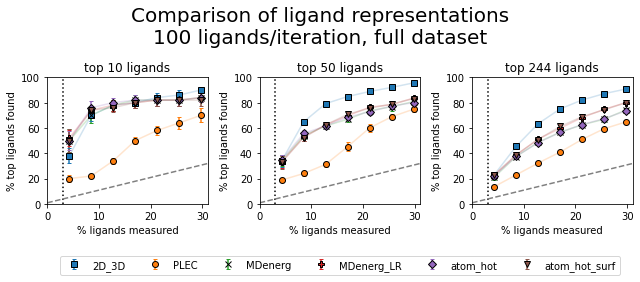

In [95]:
pgroups=["top10_found", "top50_found", "top244_found"]
labels=["top 10", "top 50", "top 244"]
sizes=[10,50,244]

markers=['s','o','x','P','D','v','^','<','>',]
alpha=0.2

# x=np.arange(len(run_mean_hist_by_sele_method[0].RMSD_XVal))
# x=100*7*(x+1)/2351 # convert to percent

n_sub_plots=len(pgroups)
fig, axs = plt.subplots(1, n_sub_plots, figsize=[n_sub_plots*3, 1*3+0.5], facecolor='w')
for sp in range(n_sub_plots):
    plt.sca(axs[sp])
    plt.xlabel("% ligands measured")
    plt.ylabel("% top ligands found")
    plt.title(labels[sp]+" ligands")
    
    for cnum in range(len(repr_method_names)):
        lbl=repr_method_names_fixed[cnum] # repr_method_names[cnum]
        atrname=pgroups[sp]
        y_avg=getattr(run_mean_hist_by_repr_method[cnum], atrname)
        y_sem=getattr(run_mean_hist_by_repr_method[cnum], atrname+"_err")
        
        x=getattr(run_mean_hist_by_repr_method[cnum], "num_known_ligs_at_step")*100/2351
        
        ls="solid"
        lw=1.5
        
        if(lbl=="narrowing"):
            plt.plot(x[:3], 100.*y_avg[:3]/sizes[sp], linestyle=ls, c=f"C{cnum}", linewidth=lw, alpha=alpha)
            plt.plot(x[3:], 100.*y_avg[3:]/sizes[sp], linestyle=ls, c=f"C{cnum}", linewidth=lw, alpha=alpha)
            plt.errorbar(x, 100.*y_avg/sizes[sp], yerr=100.*y_sem/sizes[sp], c=f"C{cnum}",
                         marker=markers[cnum], capsize=2, linestyle="None", label=lbl, markeredgecolor='k')
        else:
            plt.plot(x, 100.*y_avg/sizes[sp], linestyle=ls, c=f"C{cnum}", linewidth=lw, alpha=alpha)
            plt.errorbar(x, 100.*y_avg/sizes[sp], yerr=100.*y_sem/sizes[sp], c=f"C{cnum}",
                         marker=markers[cnum], capsize=2, linestyle="None", label=lbl, markeredgecolor='k')

    xlim=plt.gca().get_xlim()
    
    diag=np.arange(0,100, 2)
    plt.plot(diag, diag+100*20/2351, ls='dashed', color='grey')

    #plt.vlines(2.5, plt.gca().get_ylim()[0], plt.gca().get_ylim()[1], colors="black", linestyles='dotted')
    #plt.gca().set_ylim((0,250))

    #plt.vlines(100*7*(2.5+1)/2351, 0, 100, colors="black", linestyles='dotted')
    plt.vlines(100*3.5*20/2351, 0, 100, colors="black", linestyles='dotted')
    plt.gca().set_ylim((0,100))
    plt.gca().set_xlim((0,xlim[1]))

    plt.suptitle("Comparison of ligand representations\n100 ligands/iteration, full dataset", size=20)
    plt.tight_layout(rect=[0, 0.03, 1, 1.01])

#axs[1].legend(loc='lower center', bbox_to_anchor=(0.5, -0.45), ncol=4)
axs[1].legend(loc='lower center', bbox_to_anchor=(0.5, -0.6), ncol=6)
plt.show()

## fig for paper

### version for paper v1

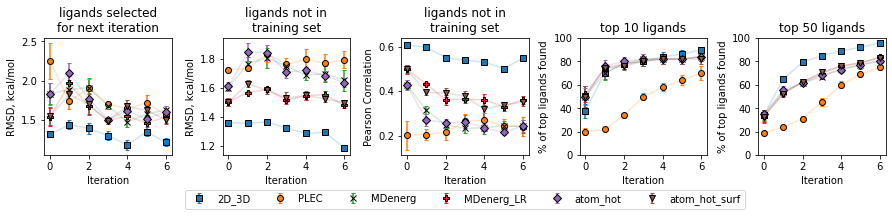

In [97]:
pgroups=["RMSD_selected", "RMSD_unmeasured",
         "KT_unmeasured",
         "top10_found", "top50_found",
         ]
y_lbls=["RMSD, kcal/mol", "RMSD, kcal/mol",
        "Kendall-tau correlation",
        "% of top ligands found", "% of top ligands found",
        ]
titles=["ligands selected\nfor next iteration", "ligands not in\ntraining set",
        "ligands not in\ntraining set",
        "top 10 ligands", "top 50 ligands"]
sizes=[0,0,0,10,50]

markers=['s','o','x','P','D','v','^','<','>',]
alpha=0.2

n_sub_plots=len(pgroups)
fig, axs = plt.subplots(1, n_sub_plots, figsize=[n_sub_plots*2.5, 1*3], facecolor='w')
for sp in range(n_sub_plots):
    plt.sca(axs[sp])
    plt.xlabel("Iteration")
    plt.ylabel(y_lbls[sp])
    plt.title(titles[sp])
    
    for cnum in range(len(repr_method_names)):
        lbl=repr_method_names_fixed[cnum] # repr_method_names[cnum]
        atrname=pgroups[sp]
        y_avg=getattr(run_mean_hist_by_repr_method[cnum], atrname)
        y_sem=getattr(run_mean_hist_by_repr_method[cnum], atrname+"_err")
        
        if("top" in pgroups[sp]): # conver y to %
            y_avg=100.*y_avg/sizes[sp]
            y_sem=100.*y_sem/sizes[sp]
        
        #x=getattr(run_mean_hist_by_repr_method[cnum], "num_known_ligs_at_step")*100/2351
        x=np.arange(len(getattr(run_mean_hist_by_repr_method[cnum], "num_known_ligs_at_step")))
        
        ls="solid"
        lw=1.5
        
        plt.plot(x, y_avg, linestyle=ls, c=f"C{cnum}", linewidth=lw, alpha=alpha)
        plt.errorbar(x, y_avg, yerr=y_sem, c=f"C{cnum}",
                     marker=markers[cnum], capsize=2, linestyle="None", label=lbl, markeredgecolor='k')

    xlim=plt.gca().get_xlim()
    
#     diag=np.arange(0,100, 2)
#     plt.plot(diag, diag+100*20/2351, ls='dashed', color='grey')

    if("top" in pgroups[sp]):
        plt.gca().set_ylim((0,100))
    plt.gca().set_xlim((min(0, xlim[0]),xlim[1]))

    #plt.suptitle("Comparison of ligand representations\n100 ligands/iteration, greedy sele rule, full dataset", size=20)
    plt.tight_layout(rect=[0, 0.07, 1, 1])


if(n_sub_plots%2==0):
    legend_shift=0    
else:
    legend_shift=0.5
axs[int(n_sub_plots/2)].legend(loc='lower center', bbox_to_anchor=(legend_shift, -0.50), ncol=6)
plt.savefig(f"{experiment_folder}/repr_comparison/repr_accuracy.png")
plt.show()

### version for paper v2

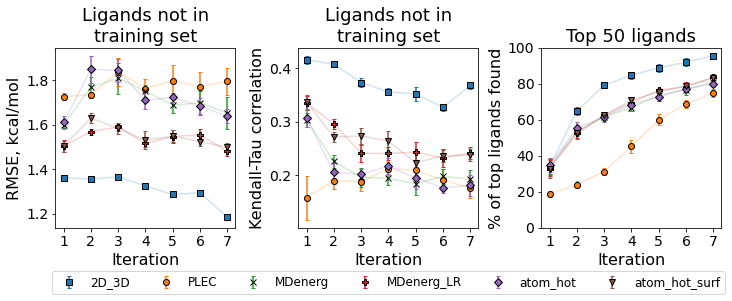

In [14]:
pgroups=["RMSD_unmeasured",
         "KT_unmeasured",
         "top50_found",
         ]
y_lbls=["RMSE, kcal/mol",
        "Kendall-Tau correlation",
        "% of top ligands found",
        ]
titles=["Ligands not in\ntraining set",
        "Ligands not in\ntraining set",
        "Top 50 ligands"]
sizes=[0,0,50]

markers=['s','o','x','P','D','v','^','<','>',]
alpha=0.2

n_sub_plots=len(pgroups)

n_sp_x=width=n_sub_plots
n_sp_y=height=1
subp_size=2.5

hspace=0.05#*(height)
wspace=0.35#*(width)

t_pad_factor_h=0.25 #of subp_size
b_pad_factor_h=0.40#0.2 #of subp_size
r_pad_factor_w=0.12#0.05 #of subp_size
l_pad_factor_w=0.30#0.32 #of subp_size
pad_factor_to_cbar=0 #of subp_size
pad_factor_w=(r_pad_factor_w+l_pad_factor_w)*0.5+pad_factor_to_cbar
pad_factor_h=(t_pad_factor_h+b_pad_factor_h)*0.5
fig_h=(height+2*pad_factor_h+(height-1)*hspace)*subp_size
fig_w=(width+2*pad_factor_w+(width-1)*wspace)*subp_size #- 0.6*subp_size

top_pad=t_pad_factor_h*subp_size/fig_h
bot_pad=b_pad_factor_h*subp_size/fig_h
right_pad=r_pad_factor_w*subp_size/fig_w
left_pad=l_pad_factor_w*subp_size/fig_w


fig, axs = plt.subplots(height, width, figsize=[fig_w, fig_h], facecolor='w')


#fig, axs = plt.subplots(1, n_sub_plots, figsize=[1.2*n_sub_plots*2.5, 1.2*1*3], facecolor='w')
for sp in range(n_sub_plots):
    plt.sca(axs[sp])
    plt.xlabel("Iteration", size=16)
    plt.ylabel(y_lbls[sp], size=16)
    plt.title(titles[sp], size=18)
        
    plt.tick_params(axis='x', labelsize=14 )
    plt.tick_params(axis='y', labelsize=14 )
    
    import matplotlib.ticker as ticker
    axs[sp].xaxis.set_major_locator(ticker.MultipleLocator(1))
#     axs[sp].xaxis.set_minor_locator(ticker.MultipleLocator(1))
    
    for cnum in range(len(repr_method_names)):
        lbl=repr_method_names_fixed[cnum] # repr_method_names[cnum]
        atrname=pgroups[sp]
        y_avg=getattr(run_mean_hist_by_repr_method[cnum], atrname)
        y_sem=getattr(run_mean_hist_by_repr_method[cnum], atrname+"_err")
        
        if("top" in pgroups[sp]): # conver y to %
            y_avg=100.*y_avg/sizes[sp]
            y_sem=100.*y_sem/sizes[sp]
        
        #x=getattr(run_mean_hist_by_repr_method[cnum], "num_known_ligs_at_step")*100/2351
        x=np.arange(len(getattr(run_mean_hist_by_repr_method[cnum], "num_known_ligs_at_step")))+1
        
        ls="solid"
        lw=1.5
        
        plt.plot(x, y_avg, linestyle=ls, c=f"C{cnum}", linewidth=lw, alpha=alpha)
        plt.errorbar(x, y_avg, yerr=y_sem, c=f"C{cnum}",
                     marker=markers[cnum], capsize=2, linestyle="None", label=lbl, markeredgecolor='k')

    xlim=plt.gca().get_xlim()
    
#     diag=np.arange(0,100, 2)
#     plt.plot(diag, diag+100*20/2351, ls='dashed', color='grey')

    if("top" in pgroups[sp]):
        plt.gca().set_ylim((0,100))
    plt.gca().set_xlim((min(1, xlim[0]),xlim[1]))

    #plt.suptitle("Comparison of ligand representations\n100 ligands/iteration, greedy sele rule, full dataset", size=20)
    #plt.tight_layout(rect=[0, 0, 1, 1])
    
plt.subplots_adjust(top=1-top_pad, right=1-right_pad, wspace=wspace, hspace=hspace, left=left_pad, bottom=bot_pad)


if(n_sub_plots%2==0):
    legend_shift=0    
else:
    legend_shift=0.5
axs[int(n_sub_plots/2)].legend(loc='lower center', bbox_to_anchor=(legend_shift, -0.40), ncol=6, prop={'size': 12})
plt.savefig(f"{experiment_folder}/repr_comparison/repr_accuracy_v2.png", dpi=300)
plt.show()

### version for paper v3

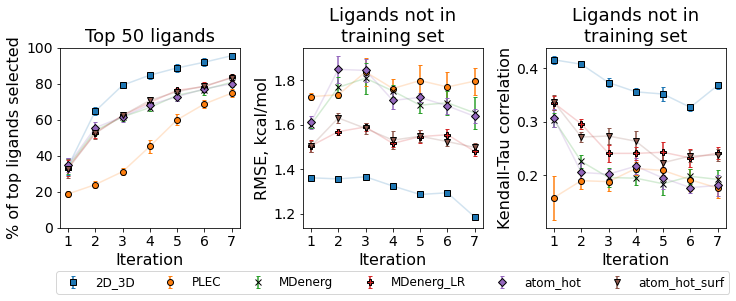

In [16]:
pgroups=["top50_found",
         "RMSD_unmeasured",
         "KT_unmeasured",
         ]
y_lbls=["% of top ligands selected",
        "RMSE, kcal/mol",
        "Kendall-Tau correlation",
        ]
titles=["Top 50 ligands",
        "Ligands not in\ntraining set",
        "Ligands not in\ntraining set",
        ]
sizes=[50,0,0]

markers=['s','o','x','P','D','v','^','<','>',]
alpha=0.2

n_sub_plots=len(pgroups)

n_sp_x=width=n_sub_plots
n_sp_y=height=1
subp_size=2.5

hspace=0.05#*(height)
wspace=0.35#*(width)

t_pad_factor_h=0.25 #of subp_size
b_pad_factor_h=0.40#0.2 #of subp_size
r_pad_factor_w=0.12#0.05 #of subp_size
l_pad_factor_w=0.30#0.32 #of subp_size
pad_factor_to_cbar=0 #of subp_size
pad_factor_w=(r_pad_factor_w+l_pad_factor_w)*0.5+pad_factor_to_cbar
pad_factor_h=(t_pad_factor_h+b_pad_factor_h)*0.5
fig_h=(height+2*pad_factor_h+(height-1)*hspace)*subp_size
fig_w=(width+2*pad_factor_w+(width-1)*wspace)*subp_size #- 0.6*subp_size

top_pad=t_pad_factor_h*subp_size/fig_h
bot_pad=b_pad_factor_h*subp_size/fig_h
right_pad=r_pad_factor_w*subp_size/fig_w
left_pad=l_pad_factor_w*subp_size/fig_w


fig, axs = plt.subplots(height, width, figsize=[fig_w, fig_h], facecolor='w')


#fig, axs = plt.subplots(1, n_sub_plots, figsize=[1.2*n_sub_plots*2.5, 1.2*1*3], facecolor='w')
for sp in range(n_sub_plots):
    plt.sca(axs[sp])
    plt.xlabel("Iteration", size=16)
    plt.ylabel(y_lbls[sp], size=16)
    plt.title(titles[sp], size=18)
        
    plt.tick_params(axis='x', labelsize=14 )
    plt.tick_params(axis='y', labelsize=14 )
    
    import matplotlib.ticker as ticker
    axs[sp].xaxis.set_major_locator(ticker.MultipleLocator(1))
#     axs[sp].xaxis.set_minor_locator(ticker.MultipleLocator(1))
    
    for cnum in range(len(repr_method_names)):
        lbl=repr_method_names_fixed[cnum] # repr_method_names[cnum]
        atrname=pgroups[sp]
        y_avg=getattr(run_mean_hist_by_repr_method[cnum], atrname)
        y_sem=getattr(run_mean_hist_by_repr_method[cnum], atrname+"_err")
        
        if("top" in pgroups[sp]): # conver y to %
            y_avg=100.*y_avg/sizes[sp]
            y_sem=100.*y_sem/sizes[sp]
        
        #x=getattr(run_mean_hist_by_repr_method[cnum], "num_known_ligs_at_step")*100/2351
        x=np.arange(len(getattr(run_mean_hist_by_repr_method[cnum], "num_known_ligs_at_step")))+1
        
        ls="solid"
        lw=1.5
        
        plt.plot(x, y_avg, linestyle=ls, c=f"C{cnum}", linewidth=lw, alpha=alpha)
        plt.errorbar(x, y_avg, yerr=y_sem, c=f"C{cnum}",
                     marker=markers[cnum], capsize=2, linestyle="None", label=lbl, markeredgecolor='k')

    xlim=plt.gca().get_xlim()
    
#     diag=np.arange(0,100, 2)
#     plt.plot(diag, diag+100*20/2351, ls='dashed', color='grey')

    if("top" in pgroups[sp]):
        plt.gca().set_ylim((0,100))
    plt.gca().set_xlim((min(1, xlim[0]),xlim[1]))

    #plt.suptitle("Comparison of ligand representations\n100 ligands/iteration, greedy sele rule, full dataset", size=20)
    #plt.tight_layout(rect=[0, 0, 1, 1])
    
plt.subplots_adjust(top=1-top_pad, right=1-right_pad, wspace=wspace, hspace=hspace, left=left_pad, bottom=bot_pad)


if(n_sub_plots%2==0):
    legend_shift=0    
else:
    legend_shift=0.5
axs[int(n_sub_plots/2)].legend(loc='lower center', bbox_to_anchor=(legend_shift, -0.40), ncol=6, prop={'size': 12})
plt.savefig(f"{experiment_folder}/repr_comparison/repr_accuracy_v3.png", dpi=300)
plt.show()

### version for paper v4

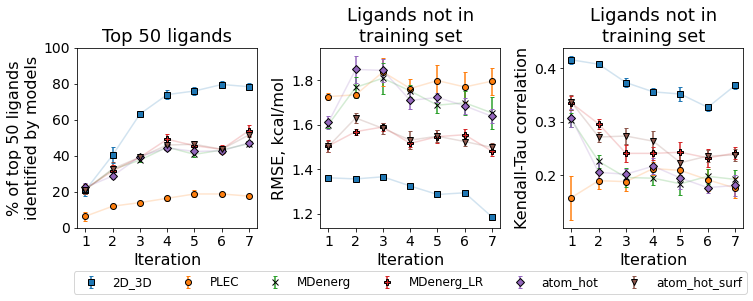

In [17]:
pgroups=["top50_correctly_predicted",
         "RMSD_unmeasured",
         "KT_unmeasured",
         ]
y_lbls=["% of top 50 ligands\nidentified by models",
        "RMSE, kcal/mol",
        "Kendall-Tau correlation",
        ]
titles=["Top 50 ligands",
        "Ligands not in\ntraining set",
        "Ligands not in\ntraining set",
        ]
sizes=[50,0,0]

markers=['s','o','x','P','D','v','^','<','>',]
alpha=0.2

n_sub_plots=len(pgroups)

n_sp_x=width=n_sub_plots
n_sp_y=height=1
subp_size=2.5

hspace=0.05#*(height)
wspace=0.35#*(width)

t_pad_factor_h=0.25 #of subp_size
b_pad_factor_h=0.40#0.2 #of subp_size
r_pad_factor_w=0.12#0.05 #of subp_size
l_pad_factor_w=0.40#0.32 #of subp_size
pad_factor_to_cbar=0 #of subp_size
pad_factor_w=(r_pad_factor_w+l_pad_factor_w)*0.5+pad_factor_to_cbar
pad_factor_h=(t_pad_factor_h+b_pad_factor_h)*0.5
fig_h=(height+2*pad_factor_h+(height-1)*hspace)*subp_size
fig_w=(width+2*pad_factor_w+(width-1)*wspace)*subp_size #- 0.6*subp_size

top_pad=t_pad_factor_h*subp_size/fig_h
bot_pad=b_pad_factor_h*subp_size/fig_h
right_pad=r_pad_factor_w*subp_size/fig_w
left_pad=l_pad_factor_w*subp_size/fig_w


fig, axs = plt.subplots(height, width, figsize=[fig_w, fig_h], facecolor='w')


#fig, axs = plt.subplots(1, n_sub_plots, figsize=[1.2*n_sub_plots*2.5, 1.2*1*3], facecolor='w')
for sp in range(n_sub_plots):
    plt.sca(axs[sp])
    plt.xlabel("Iteration", size=16)
    plt.ylabel(y_lbls[sp], size=16)
    plt.title(titles[sp], size=18)
        
    plt.tick_params(axis='x', labelsize=14 )
    plt.tick_params(axis='y', labelsize=14 )
    
    import matplotlib.ticker as ticker
    axs[sp].xaxis.set_major_locator(ticker.MultipleLocator(1))
#     axs[sp].xaxis.set_minor_locator(ticker.MultipleLocator(1))
    
    for cnum in range(len(repr_method_names)):
        lbl=repr_method_names_fixed[cnum] # repr_method_names[cnum]
        atrname=pgroups[sp]
        y_avg=getattr(run_mean_hist_by_repr_method[cnum], atrname)
        y_sem=getattr(run_mean_hist_by_repr_method[cnum], atrname+"_err")
        
        if("top" in pgroups[sp]): # conver y to %
            y_avg=100.*y_avg/sizes[sp]
            y_sem=100.*y_sem/sizes[sp]
            plt.gca().set_ylim(0,100)
        
        #x=getattr(run_mean_hist_by_repr_method[cnum], "num_known_ligs_at_step")*100/2351
        x=np.arange(len(getattr(run_mean_hist_by_repr_method[cnum], "num_known_ligs_at_step")))+1
        
        ls="solid"
        lw=1.5
        
        plt.plot(x, y_avg, linestyle=ls, c=f"C{cnum}", linewidth=lw, alpha=alpha)
        plt.errorbar(x, y_avg, yerr=y_sem, c=f"C{cnum}",
                     marker=markers[cnum], capsize=2, linestyle="None", label=lbl, markeredgecolor='k')

    xlim=plt.gca().get_xlim()
    
#     diag=np.arange(0,100, 2)
#     plt.plot(diag, diag+100*20/2351, ls='dashed', color='grey')

    if("top" in pgroups[sp]):
        plt.gca().set_ylim((0,100))
    plt.gca().set_xlim((min(1, xlim[0]),xlim[1]))

    #plt.suptitle("Comparison of ligand representations\n100 ligands/iteration, greedy sele rule, full dataset", size=20)
    #plt.tight_layout(rect=[0, 0, 1, 1])
    
plt.subplots_adjust(top=1-top_pad, right=1-right_pad, wspace=wspace, hspace=hspace, left=left_pad, bottom=bot_pad)


if(n_sub_plots%2==0):
    legend_shift=0    
else:
    legend_shift=0.5
axs[int(n_sub_plots/2)].legend(loc='lower center', bbox_to_anchor=(legend_shift, -0.40), ncol=6, prop={'size': 12})
plt.savefig(f"{experiment_folder}/repr_comparison/repr_accuracy_v4.png", dpi=300)
plt.show()

### older version

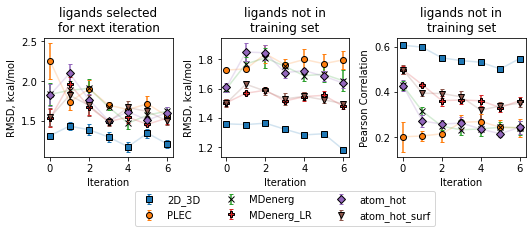

In [58]:
pgroups=["RMSD_selected", "RMSD_unmeasured",
         "Cor_unmeasured",
         ]
y_lbls=["RMSD, kcal/mol", "RMSD, kcal/mol",
        "Pearson Correlation",
        ]
titles=["ligands selected\nfor next iteration", "ligands not in\ntraining set",
        "ligands not in\ntraining set"]
sizes=[0,0,0]

markers=['s','o','x','P','D','v','^','<','>',]
alpha=0.2

n_sub_plots=len(pgroups)
fig, axs = plt.subplots(1, n_sub_plots, figsize=[n_sub_plots*2.5, 1*3.2], facecolor='w')
for sp in range(n_sub_plots):
    plt.sca(axs[sp])
    plt.xlabel("Iteration")
    plt.ylabel(y_lbls[sp])
    plt.title(titles[sp])
    
    for cnum in range(len(repr_method_names)):
        lbl=repr_method_names_fixed[cnum] # repr_method_names[cnum]
        atrname=pgroups[sp]
        y_avg=getattr(run_mean_hist_by_repr_method[cnum], atrname)
        y_sem=getattr(run_mean_hist_by_repr_method[cnum], atrname+"_err")
        
        if("top" in pgroups[sp]): # conver y to %
            y_avg=100.*y_avg/sizes[sp]
            y_sem=100.*y_sem/sizes[sp]
        
        #x=getattr(run_mean_hist_by_repr_method[cnum], "num_known_ligs_at_step")*100/2351
        x=np.arange(len(getattr(run_mean_hist_by_repr_method[cnum], "num_known_ligs_at_step")))
        
        ls="solid"
        lw=1.5
        
        plt.plot(x, y_avg, linestyle=ls, c=f"C{cnum}", linewidth=lw, alpha=alpha)
        plt.errorbar(x, y_avg, yerr=y_sem, c=f"C{cnum}",
                     marker=markers[cnum], capsize=2, linestyle="None", label=lbl, markeredgecolor='k')

    xlim=plt.gca().get_xlim()
    
#     diag=np.arange(0,100, 2)
#     plt.plot(diag, diag+100*20/2351, ls='dashed', color='grey')

    if("top" in pgroups[sp]):
        plt.gca().set_ylim((0,100))
    plt.gca().set_xlim((min(0, xlim[0]),xlim[1]))

    #plt.suptitle("Comparison of ligand representations\n100 ligands/iteration, greedy sele rule, full dataset", size=20)
    plt.tight_layout(rect=[0, 0.12, 1, 1])


if(n_sub_plots%2==0):
    legend_shift=0    
else:
    legend_shift=0.5
axs[int(n_sub_plots/2)].legend(loc='lower center', bbox_to_anchor=(legend_shift, -0.62), ncol=3)
plt.savefig(f"{experiment_folder}/repr_comparison/repr_accuracy_mini.png", dpi=300)
plt.show()

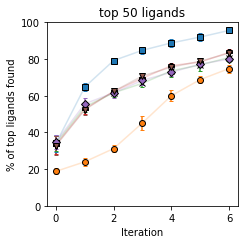

In [65]:
pgroups=["top50_found",
         ]
y_lbls=["% of top ligands found",
        ]
titles=["top 50 ligands"]
sizes=[50]

markers=['s','o','x','P','D','v','^','<','>',]
alpha=0.2

n_sub_plots=len(pgroups)
fig, axs = plt.subplots(1, n_sub_plots, figsize=[n_sub_plots*3.5, 1*3.5], facecolor='w')
for sp in range(n_sub_plots):
    plt.sca(axs)
    plt.xlabel("Iteration")
    plt.ylabel(y_lbls[sp])
    plt.title(titles[sp])
    
    for cnum in range(len(repr_method_names)):
        lbl=repr_method_names_fixed[cnum] # repr_method_names[cnum]
        atrname=pgroups[sp]
        y_avg=getattr(run_mean_hist_by_repr_method[cnum], atrname)
        y_sem=getattr(run_mean_hist_by_repr_method[cnum], atrname+"_err")
        
        if("top" in pgroups[sp]): # conver y to %
            y_avg=100.*y_avg/sizes[sp]
            y_sem=100.*y_sem/sizes[sp]
        
        #x=getattr(run_mean_hist_by_repr_method[cnum], "num_known_ligs_at_step")*100/2351
        x=np.arange(len(getattr(run_mean_hist_by_repr_method[cnum], "num_known_ligs_at_step")))
        
        ls="solid"
        lw=1.5
        
        plt.plot(x, y_avg, linestyle=ls, c=f"C{cnum}", linewidth=lw, alpha=alpha)
        plt.errorbar(x, y_avg, yerr=y_sem, c=f"C{cnum}",
                     marker=markers[cnum], capsize=2, linestyle="None", label=lbl, markeredgecolor='k')

    xlim=plt.gca().get_xlim()
    
#     diag=np.arange(0,100, 2)
#     plt.plot(diag, diag+100*20/2351, ls='dashed', color='grey')

    if("top" in pgroups[sp]):
        plt.gca().set_ylim((0,100))
    plt.gca().set_xlim((min(0, xlim[0]),xlim[1]))

# #plt.suptitle("Comparison of ligand representations\n100 ligands/iteration, greedy sele rule, full dataset", size=20)
    plt.tight_layout()


# if(n_sub_plots%2==0):
#     legend_shift=0    
# else:
#     legend_shift=0.5
# axs[int(n_sub_plots/2)].legend(loc='lower center', bbox_to_anchor=(legend_shift, -0.50), ncol=6)
plt.savefig(f"{experiment_folder}/repr_comparison/repr_accuracy_top_50_big.png", dpi=300)
plt.show()

# convergence to same ligands

In [18]:
with open(all_ligs_db_file, 'rb') as f:
    all_ligs = pickle.load(f)
    
dGs=np.array([float(lig.GetProp('dG')) for lig in all_ligs])

In [20]:
def bootstrap_pairs(pairs, func, reps=1000):
    results=np.zeros(reps)
    l=len(pairs)
    for i in range(reps):
        sample_indeces=np.random.choice(l, l, replace=True)
        samples=[pairs[j] for j in sample_indeces] # looks like argl to the func
        results[i]=func(samples)

    ret = np.std(results)
    return(ret)

def num_common_func(pairs):
    n_common=[]
    for i in range(len(pairs)):
        a=pairs[i][0]
        b=pairs[i][1]
        n_common.append(len(np.intersect1d(a,b)))
    return(np.mean(n_common))

### convergence of top 50 sampled ligands

In [21]:
# load the repeats of the protocol

#ignore the binned ones
good_repr_ids=[i for i in range(len(possible_repr_names)) if not "binned" in possible_repr_names[i]]
repr_method_names=[possible_repr_names[i] for i in good_repr_ids]

n_top_ligs=[10,20,30,40,50,60,70,80,90,100]
common_top_n_ligs=[]
common_top_n_ligs_err=[]
for sid in range(len([repr_method_sfiles[i] for i in good_repr_ids])):
    
    top_found_ids=[]
    for fn in repr_method_sfiles[sid]:
        with open(fn, 'rb') as f:
            learner_settings, learner_metrics = pickle.load(f)
            knowndGs=dGs[learner_metrics.known_lig_ids]
            best=learner_metrics.known_lig_ids[np.argsort(knowndGs)]
            top_ns_found_ids=[]
            for n in n_top_ligs:
                top_ns_found_ids.append(best[:n])
            top_found_ids.append(top_ns_found_ids)

    this_repr_top_n_common=[]
    this_repr_top_n_common_err=[]
    for n in range(len(n_top_ligs)):
        n_common=[]
        pairs=[]
        for i in range(len(repr_method_sfiles[sid])-1):
            for j in range(i,len(repr_method_sfiles[sid])):
                a=top_found_ids[i][n]
                b=top_found_ids[j][n]
                n_common.append(len(np.intersect1d(a,b)))
                pairs.append((a,b))

        this_repr_top_n_common.append(np.mean(n_common))
        #this_repr_top_n_common_err.append(np.std(n_common))
        this_repr_top_n_common_err.append( bootstrap_pairs(pairs, num_common_func) )
    common_top_n_ligs.append(np.array(this_repr_top_n_common))
    common_top_n_ligs_err.append(np.array(this_repr_top_n_common_err))

In [22]:
for i in range(len(good_repr_ids)):
    #print(f"{possible_repr_names[i]:25s}:\t{common_top_10[i]/10:.2f}+-{common_top_10_err[i]/10:.2f}")
    print(f"{possible_repr_names[good_repr_ids[i]]:25s}:", end='')
    for n in range(len(n_top_ligs)):
        print(f"\t{common_top_n_ligs[i][n]/n_top_ligs[n]:.2f}+-{common_top_n_ligs_err[i][n]/n_top_ligs[n]:.2f}", end='')
    print()

2D_3D                    :	1.00+-0.00	1.00+-0.00	0.98+-0.00	0.98+-0.00	0.98+-0.00	0.98+-0.00	0.97+-0.00	0.98+-0.00	0.98+-0.00	0.98+-0.00
PLEC_filtered            :	0.86+-0.03	0.90+-0.02	0.89+-0.02	0.91+-0.02	0.92+-0.02	0.90+-0.02	0.90+-0.02	0.90+-0.02	0.89+-0.02	0.89+-0.02
MDenerg                  :	0.89+-0.03	0.90+-0.02	0.87+-0.02	0.88+-0.02	0.90+-0.02	0.91+-0.02	0.91+-0.02	0.91+-0.02	0.92+-0.02	0.91+-0.02
MDenerg_long_cut         :	0.89+-0.03	0.93+-0.02	0.90+-0.02	0.89+-0.02	0.91+-0.02	0.92+-0.02	0.92+-0.02	0.93+-0.01	0.93+-0.01	0.93+-0.01
atom_hot                 :	0.89+-0.02	0.92+-0.02	0.88+-0.03	0.91+-0.02	0.92+-0.02	0.92+-0.02	0.92+-0.02	0.92+-0.02	0.93+-0.02	0.92+-0.02
atom_hot_surf            :	0.86+-0.04	0.91+-0.02	0.89+-0.02	0.89+-0.02	0.91+-0.02	0.92+-0.02	0.92+-0.02	0.92+-0.02	0.92+-0.02	0.92+-0.02


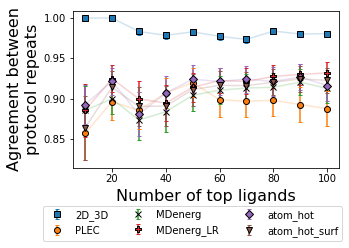

In [23]:
markers=['s','o','x','P','D','v','^','<','>',]
alpha=0.2

fig = plt.figure(figsize=[5, 3.5], facecolor='w')
plt.xlabel("Number of top ligands", size=16)
plt.ylabel("Agreement between\nprotocol repeats", size=16)

    
for cnum in range(len(repr_method_names)):
    lbl=repr_method_names_fixed[cnum] # repr_method_names[cnum]
    y_avg=common_top_n_ligs[cnum]/np.array(n_top_ligs)
    y_sem=common_top_n_ligs_err[cnum]/np.array(n_top_ligs)

    x=n_top_ligs

    ls="solid"
    lw=1.5

    plt.plot(x, y_avg, linestyle=ls, c=f"C{cnum}", linewidth=lw, alpha=alpha)
    plt.errorbar(x, y_avg, yerr=y_sem, c=f"C{cnum}",
                 marker=markers[cnum], capsize=2, linestyle="None", label=lbl, markeredgecolor='k')

    xlim=plt.gca().get_xlim()

plt.tight_layout(rect=[0, 0.15, 1, 1])
plt.legend(loc='lower center', bbox_to_anchor=(0.45, -0.50), ncol=3)

plt.savefig(f"{experiment_folder}/repr_comparison/repr_agreement.png")
plt.show()

In [24]:
# load the repeats of the protocol

iterations=np.arange(7)
common_top_it_ligs=[]
common_top_it_ligs_err=[]

n=50
for sid in range(len([repr_method_sfiles[i] for i in good_repr_ids])): 
    top_found_ids=[]
    for fn in repr_method_sfiles[sid]:
        with open(fn, 'rb') as f:
            learner_settings, learner_metrics = pickle.load(f)
            
            top_its_found_ids={}
            known_at_this_iter=learner_metrics.known_lig_ids
            for it in np.flip(iterations):
                knowndGs=dGs[known_at_this_iter]
                best=known_at_this_iter[np.argsort(knowndGs)]
                top_its_found_ids[it]=best[:n]
                # update known
                known_at_this_iter=np.array([i for i in known_at_this_iter if not i in learner_metrics.step_lig_ids[it]])
            top_found_ids.append(top_its_found_ids)


    this_sele_top_it_common=[]
    this_sele_top_it_common_err=[]
    for it in iterations:
        n_common=[]
        pairs=[]
        for i in range(len(repr_method_sfiles[sid])-1):
            for j in range(i,len(repr_method_sfiles[sid])):
                a=top_found_ids[i][it]
                b=top_found_ids[j][it]
                n_common.append(len(np.intersect1d(a,b)))
                pairs.append((a,b))

        this_sele_top_it_common.append(np.mean(n_common))
        this_sele_top_it_common_err.append( bootstrap_pairs(pairs, num_common_func) )
    common_top_it_ligs.append(np.array(this_sele_top_it_common))
    common_top_it_ligs_err.append(np.array(this_sele_top_it_common_err))
    #raise()

In [25]:
print(f"{'':25s}", end='')
for it in iterations:
    print(f"\t{it:^10d}", end='')
print()
for i in range(len(good_repr_ids)):
    print(f"{possible_repr_names[good_repr_ids[i]]:25s}:", end='')
    for it in iterations:
        print(f"\t{common_top_it_ligs[i][it]/n:.2f}+-{common_top_it_ligs_err[i][it]/n:.2f}", end='')
    print()

                         	    0     	    1     	    2     	    3     	    4     	    5     	    6     
2D_3D                    :	0.43+-0.10	0.60+-0.07	0.82+-0.03	0.91+-0.02	0.93+-0.01	0.96+-0.01	0.98+-0.00
PLEC_filtered            :	0.36+-0.11	0.45+-0.10	0.57+-0.08	0.67+-0.06	0.72+-0.05	0.85+-0.03	0.92+-0.02
MDenerg                  :	0.40+-0.10	0.58+-0.08	0.78+-0.04	0.89+-0.02	0.91+-0.02	0.90+-0.02	0.90+-0.02
MDenerg_long_cut         :	0.38+-0.11	0.58+-0.08	0.79+-0.05	0.90+-0.02	0.92+-0.02	0.92+-0.02	0.91+-0.02
atom_hot                 :	0.37+-0.11	0.58+-0.07	0.84+-0.03	0.90+-0.02	0.91+-0.02	0.92+-0.02	0.92+-0.02
atom_hot_surf            :	0.41+-0.10	0.58+-0.08	0.79+-0.05	0.90+-0.02	0.91+-0.02	0.91+-0.02	0.91+-0.02


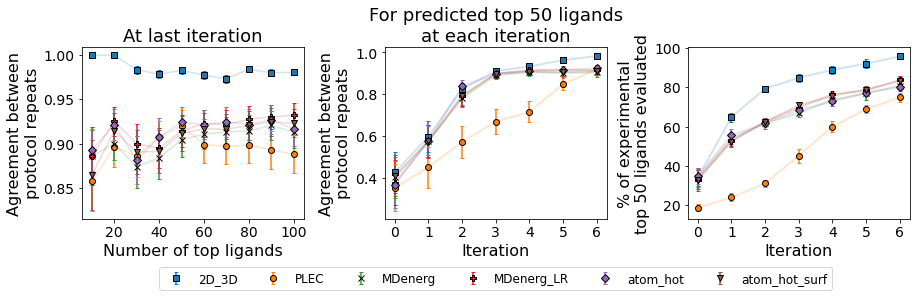

In [26]:
import matplotlib.ticker as ticker
titles=["ligands selected\nfor next iteration", "ligands not in\ntraining set"]

markers=['s','o','x','P','D','v','^','<','>',]
alpha=0.2

n_sub_plots=3
fig, axs = plt.subplots(1, n_sub_plots, figsize=[1.2*n_sub_plots*3.6, 1.2*1*3.6], facecolor='w')


# agreement vs n
plt.sca(axs[0])
plt.xlabel("Number of top ligands", size=16)
plt.ylabel("Agreement between\nprotocol repeats", size=16)
plt.title("At last iteration", size=18)

plt.tick_params(axis='x', labelsize=14 )
plt.tick_params(axis='y', labelsize=14 )
    
for cnum in range(len(repr_method_names)):
    lbl=repr_method_names_fixed[cnum] # repr_method_names[cnum]
    y_avg=common_top_n_ligs[cnum]/np.array(n_top_ligs)
    y_sem=common_top_n_ligs_err[cnum]/np.array(n_top_ligs)

    x=n_top_ligs

    ls="solid"
    lw=1.5

    plt.plot(x, y_avg, linestyle=ls, c=f"C{cnum}", linewidth=lw, alpha=alpha)
    plt.errorbar(x, y_avg, yerr=y_sem, c=f"C{cnum}",
                 marker=markers[cnum], capsize=2, linestyle="None", label=lbl, markeredgecolor='k')

    xlim=plt.gca().get_xlim()
    
    
    
# agreement vs it
plt.sca(axs[1])
plt.xlabel("Iteration", size=16)
plt.ylabel("Agreement between\nprotocol repeats", size=16)
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.title("For predicted top 50 ligands\nat each iteration", size=18)

plt.tick_params(axis='x', labelsize=14 )
plt.tick_params(axis='y', labelsize=14 )

# plt.gca().axes.yaxis.set_ticklabels([])
# plt.gca().set_ylabel("")


for cnum in range(len(repr_method_names)):
    lbl=repr_method_names_fixed[cnum] # repr_method_names[cnum]
    y_avg=common_top_it_ligs[cnum]/50
    y_sem=common_top_it_ligs_err[cnum]/50

    x=np.arange(7)

    ls="solid"
    lw=2

    plt.plot(x, y_avg, linestyle=ls, c=f"C{cnum}", linewidth=lw, alpha=alpha)
    plt.errorbar(x, y_avg, yerr=y_sem, c=f"C{cnum}",
                 marker=markers[cnum], capsize=2, linestyle="None", label=lbl, markeredgecolor='k')

# xlim=plt.gca().get_xlim()
# ylim=plt.gca().get_ylim()
# plt.vlines(2.5, ylim[0], ylim[1], colors="black", linestyles='dotted')
# plt.gca().set_xlim((min(0,xlim[0]),xlim[1]))

#plt.suptitle("Convergence metrics for top 50 strongest binding ligands", size=20)




# num found vs it
plt.sca(axs[2])
plt.xlabel("Iteration", size=16)
plt.ylabel("% of experimental\ntop 50 ligands evaluated", size=16)
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
#plt.title("For top 50 ligands\nat each iteration", size=18)

plt.tick_params(axis='x', labelsize=14 )
plt.tick_params(axis='y', labelsize=14 )

# plt.gca().axes.yaxis.set_ticklabels([])
# plt.gca().set_ylabel("")


for cnum in range(len(repr_method_names)):
    lbl=repr_method_names_fixed[cnum] # repr_method_names[cnum]   
    atrname="top50_found"
    y_avg=getattr(run_mean_hist_by_repr_method[cnum], atrname)*100.0/50
    y_sem=getattr(run_mean_hist_by_repr_method[cnum], atrname+"_err")*100.0/50

    x=np.arange(7)

    ls="solid"
    lw=2

    plt.plot(x, y_avg, linestyle=ls, c=f"C{cnum}", linewidth=lw, alpha=alpha)
    plt.errorbar(x, y_avg, yerr=y_sem, c=f"C{cnum}",
                 marker=markers[cnum], capsize=2, linestyle="None", label=lbl, markeredgecolor='k')


plt.tight_layout(rect=[0, 0.12, 1, 1])

#axs[1].legend(loc='lower center', bbox_to_anchor=(-0.03, -0.52), ncol=3, prop={'size': 12})
axs[1].legend(loc='lower center', bbox_to_anchor=(0.5, -0.45), ncol=6, prop={'size': 12})

plt.savefig(f"{experiment_folder}/repr_comparison/repr_agreement.png",
                dpi='figure',
                facecolor='w'
               )
plt.show()

### convergence of top model predictions

In [27]:
print(P_per_repr[0][0][6])

[-13.098841   -8.473494  -12.890921  ...  -6.5158567  -7.376924
  -6.143904 ]


In [28]:
#P_per_repr[sid][0]
# load the repeats of the protocol

#ignore the binned ones
good_repr_ids=[i for i in range(len(possible_repr_names)) if not "binned" in possible_repr_names[i]]
repr_method_names=[possible_repr_names[i] for i in good_repr_ids]

n_top_ligs=[10,20,30,40,50,60,70,80,90,100]
common_pred_top_n_ligs=[]
common_pred_top_n_ligs_err=[]
for sid in range(len([repr_method_sfiles[i] for i in good_repr_ids])):
    
    top_pred_ids=[]
    nrepeats=len(P_per_repr[sid])
    for repeat in range(nrepeats):
        P=P_per_repr[sid][repeat][-1] # at last iter
        best=np.argsort(P)
        top_ns_pred_ids=[]
        for n in n_top_ligs:
            top_ns_pred_ids.append(best[:n])
        top_pred_ids.append(top_ns_pred_ids)

    this_repr_top_n_pred_common=[]
    this_repr_top_n_pred_common_err=[]
    for n in range(len(n_top_ligs)):
        n_common=[]
        pairs=[]
        for i in range(nrepeats-1):
            for j in range(i,nrepeats):
                a=top_pred_ids[i][n]
                b=top_pred_ids[j][n]
                n_common.append(len(np.intersect1d(a,b)))
                pairs.append((a,b))

        this_repr_top_n_pred_common.append(np.mean(n_common))
        #this_repr_top_n_common_err.append(np.std(n_common))
        this_repr_top_n_pred_common_err.append( bootstrap_pairs(pairs, num_common_func) )
    common_pred_top_n_ligs.append(np.array(this_repr_top_n_pred_common))
    common_pred_top_n_ligs_err.append(np.array(this_repr_top_n_pred_common_err))

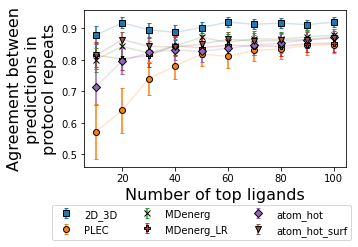

In [29]:
markers=['s','o','x','P','D','v','^','<','>',]
alpha=0.2

fig = plt.figure(figsize=[5, 3.5], facecolor='w')
plt.xlabel("Number of top ligands", size=16)
plt.ylabel("Agreement between\npredictions in\nprotocol repeats", size=16)

    
for cnum in range(len(repr_method_names)):
    lbl=repr_method_names_fixed[cnum] # repr_method_names[cnum]
    y_avg=common_pred_top_n_ligs[cnum]/np.array(n_top_ligs)
    y_sem=common_pred_top_n_ligs_err[cnum]/np.array(n_top_ligs)

    x=n_top_ligs

    ls="solid"
    lw=1.5

    plt.plot(x, y_avg, linestyle=ls, c=f"C{cnum}", linewidth=lw, alpha=alpha)
    plt.errorbar(x, y_avg, yerr=y_sem, c=f"C{cnum}",
                 marker=markers[cnum], capsize=2, linestyle="None", label=lbl, markeredgecolor='k')

    xlim=plt.gca().get_xlim()

plt.tight_layout(rect=[0, 0.15, 1, 1])
plt.legend(loc='lower center', bbox_to_anchor=(0.45, -0.50), ncol=3)

plt.show()

In [30]:
# load the repeats of the protocol

iterations=np.arange(7)
common_top_pred_it_ligs=[]
common_top_pred_it_ligs_err=[]

n=50
for sid in range(len([repr_method_sfiles[i] for i in good_repr_ids])): 
    top_pred_ids=[]
    nrepeats=len(P_per_repr[sid])
    for repeat in range(nrepeats):
        top_its_pred_ids={}
        for it in iterations:
            P=P_per_repr[sid][repeat][it] # at last iter
            best=np.argsort(P)
            top_its_pred_ids[it]=best[:n]
        top_pred_ids.append(top_its_pred_ids)

    this_sele_top_it_pred_common=[]
    this_sele_top_it_pred_common_err=[]
    for it in iterations:
        n_common=[]
        pairs=[]
        for i in range(nrepeats-1):
            for j in range(i,nrepeats):
                a=top_pred_ids[i][it]
                b=top_pred_ids[j][it]
                n_common.append(len(np.intersect1d(a,b)))
                pairs.append((a,b))

        this_sele_top_it_pred_common.append(np.mean(n_common))
        this_sele_top_it_pred_common_err.append( bootstrap_pairs(pairs, num_common_func) )
    common_top_pred_it_ligs.append(np.array(this_sele_top_it_pred_common))
    common_top_pred_it_ligs_err.append(np.array(this_sele_top_it_pred_common_err))
    #raise()

In [31]:
print(f"{'':25s}", end='')
for it in iterations:
    print(f"\t{it:^10d}", end='')
print()
for i in range(len(good_repr_ids)):
    print(f"{possible_repr_names[good_repr_ids[i]]:25s}:", end='')
    for it in iterations:
        print(f"\t{common_top_pred_it_ligs[i][it]/n:.2f}+-{common_top_pred_it_ligs_err[i][it]/n:.2f}", end='')
    print()

                         	    0     	    1     	    2     	    3     	    4     	    5     	    6     
2D_3D                    :	0.46+-0.09	0.65+-0.06	0.83+-0.03	0.87+-0.02	0.88+-0.02	0.89+-0.02	0.90+-0.02
PLEC_filtered            :	0.37+-0.11	0.45+-0.11	0.55+-0.08	0.66+-0.07	0.70+-0.06	0.82+-0.04	0.82+-0.04
MDenerg                  :	0.47+-0.09	0.63+-0.07	0.76+-0.04	0.78+-0.04	0.82+-0.03	0.81+-0.03	0.87+-0.02
MDenerg_long_cut         :	0.49+-0.09	0.59+-0.07	0.79+-0.04	0.78+-0.04	0.83+-0.03	0.87+-0.03	0.84+-0.03
atom_hot                 :	0.47+-0.09	0.65+-0.06	0.78+-0.04	0.84+-0.03	0.78+-0.04	0.84+-0.03	0.83+-0.04
atom_hot_surf            :	0.49+-0.09	0.59+-0.08	0.74+-0.05	0.81+-0.04	0.85+-0.03	0.86+-0.03	0.85+-0.03


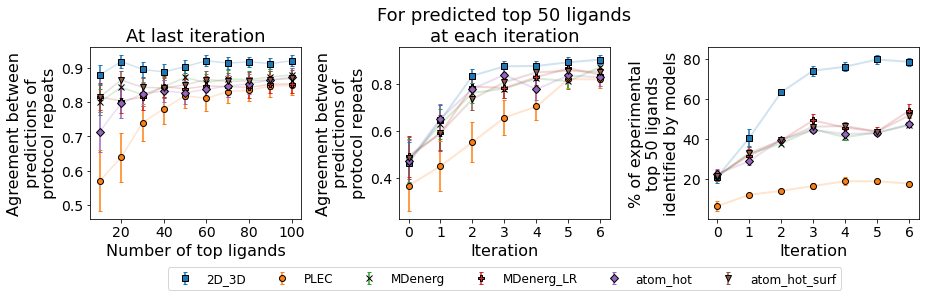

In [32]:
import matplotlib.ticker as ticker
titles=["ligands selected\nfor next iteration", "ligands not in\ntraining set"]

markers=['s','o','x','P','D','v','^','<','>',]
alpha=0.2

n_sub_plots=3
fig, axs = plt.subplots(1, n_sub_plots, figsize=[1.2*n_sub_plots*3.6, 1.2*1*3.6], facecolor='w')


# agreement vs n
plt.sca(axs[0])
plt.xlabel("Number of top ligands", size=16)
plt.ylabel("Agreement between\npredictions of\nprotocol repeats", size=16)
plt.title("At last iteration", size=18)

plt.tick_params(axis='x', labelsize=14 )
plt.tick_params(axis='y', labelsize=14 )
    
for cnum in range(len(repr_method_names)):
    lbl=repr_method_names_fixed[cnum] # repr_method_names[cnum]
    y_avg=common_pred_top_n_ligs[cnum]/np.array(n_top_ligs)
    y_sem=common_pred_top_n_ligs_err[cnum]/np.array(n_top_ligs)

    x=n_top_ligs

    ls="solid"
    lw=1.5

    plt.plot(x, y_avg, linestyle=ls, c=f"C{cnum}", linewidth=lw, alpha=alpha)
    plt.errorbar(x, y_avg, yerr=y_sem, c=f"C{cnum}",
                 marker=markers[cnum], capsize=2, linestyle="None", label=lbl, markeredgecolor='k')

    xlim=plt.gca().get_xlim()
    
    
    
# agreement vs it
plt.sca(axs[1])
plt.xlabel("Iteration", size=16)
plt.ylabel("Agreement between\npredictions of\nprotocol repeats", size=16)
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.title("For predicted top 50 ligands\nat each iteration", size=18)

plt.tick_params(axis='x', labelsize=14 )
plt.tick_params(axis='y', labelsize=14 )

# plt.gca().axes.yaxis.set_ticklabels([])
# plt.gca().set_ylabel("")


for cnum in range(len(repr_method_names)):
    lbl=repr_method_names_fixed[cnum] # repr_method_names[cnum]
    y_avg=common_top_pred_it_ligs[cnum]/50
    y_sem=common_top_pred_it_ligs_err[cnum]/50

    x=np.arange(7)

    ls="solid"
    lw=2

    plt.plot(x, y_avg, linestyle=ls, c=f"C{cnum}", linewidth=lw, alpha=alpha)
    plt.errorbar(x, y_avg, yerr=y_sem, c=f"C{cnum}",
                 marker=markers[cnum], capsize=2, linestyle="None", label=lbl, markeredgecolor='k')

# xlim=plt.gca().get_xlim()
# ylim=plt.gca().get_ylim()
# plt.vlines(2.5, ylim[0], ylim[1], colors="black", linestyles='dotted')
# plt.gca().set_xlim((min(0,xlim[0]),xlim[1]))

#plt.suptitle("Convergence metrics for top 50 strongest binding ligands", size=20)




# num found vs it
plt.sca(axs[2])
plt.xlabel("Iteration", size=16)
plt.ylabel("% of experimental\ntop 50 ligands\nidentified by models", size=16)
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
#plt.title("For top 50 ligands\nat each iteration", size=18)

plt.tick_params(axis='x', labelsize=14 )
plt.tick_params(axis='y', labelsize=14 )

# plt.gca().axes.yaxis.set_ticklabels([])
# plt.gca().set_ylabel("")


for cnum in range(len(repr_method_names)):
    lbl=repr_method_names_fixed[cnum] # repr_method_names[cnum]   
    #atrname="top50_found"
    atrname="top50_correctly_predicted"
    y_avg=getattr(run_mean_hist_by_repr_method[cnum], atrname)*100.0/50
    y_sem=getattr(run_mean_hist_by_repr_method[cnum], atrname+"_err")*100.0/50

    x=np.arange(7)

    ls="solid"
    lw=2

    plt.plot(x, y_avg, linestyle=ls, c=f"C{cnum}", linewidth=lw, alpha=alpha)
    plt.errorbar(x, y_avg, yerr=y_sem, c=f"C{cnum}",
                 marker=markers[cnum], capsize=2, linestyle="None", label=lbl, markeredgecolor='k')


plt.tight_layout(rect=[0, 0.12, 1, 1])

#axs[1].legend(loc='lower center', bbox_to_anchor=(-0.03, -0.52), ncol=3, prop={'size': 12})
axs[1].legend(loc='lower center', bbox_to_anchor=(0.5, -0.45), ncol=6, prop={'size': 12})

plt.savefig(f"{experiment_folder}/repr_comparison/repr_agreement_v2.png",
                dpi='figure',
                facecolor='w'
               )
plt.show()

# Debug

In [34]:
with open(all_ligs_db_file, 'rb') as f:
    all_ligs = pickle.load(f)
    
print(len(all_ligs))

2351


# Feature groups and their sizes

In [47]:
test_ligs=all_ligs

from custom_dataset_modular_with_binning_6EZF import dataBlocks, CustomMolModularDataset


for b in flags_2D_3D:

    representation_flags=[0]*len(dataBlocks)
    representation_flags[int(b)]=1
    
                
    test_DS = CustomMolModularDataset(
        ligs=test_ligs,
        #no_core_ligs=no_core_all_ligs,
        no_core_ligs=None,
        use_combined_cache=False, use_hdf5_cache=False,
        representation_flags=representation_flags, normalize_x=False,
        X_filter=None,
        datafolder="/home/ykhalak/Projects/ML_dG/pde2_dG/retrospective_active_learning_in_6EZF/cached_reprs/"
    )
    
    print(dataBlocks(b).name, test_DS[0][0].shape)

MACCS (167,)
Descriptors (208,)
Graph_desc (17,)
BCUT2D (8,)
EState_FP (174,)
Pharmacophore_feature_map (358,)
MOE (0,)
MQN (42,)
GETAWAY (273,)
AUTOCORR2D (192,)
AUTOCORR3D (80,)
WHIM (114,)
RDF (210,)
USR (12,)
USRCUT (60,)
PEOE_VSA (14,)
SMR_VSA (10,)
SlogP_VSA (12,)
MORSE (224,)


In [45]:
print(len(Descriptors._descList))
print(Descriptors._descList)

208
[('MaxEStateIndex', <function MaxEStateIndex at 0x7f2b72bfa378>), ('MinEStateIndex', <function MinEStateIndex at 0x7f2b72bfa400>), ('MaxAbsEStateIndex', <function MaxAbsEStateIndex at 0x7f2b72bfa488>), ('MinAbsEStateIndex', <function MinAbsEStateIndex at 0x7f2b72bfa510>), ('qed', <function qed at 0x7f2b72a311e0>), ('MolWt', <function <lambda> at 0x7f2b72a31488>), ('HeavyAtomMolWt', <function HeavyAtomMolWt at 0x7f2b72a31510>), ('ExactMolWt', <function <lambda> at 0x7f2b72a31598>), ('NumValenceElectrons', <function NumValenceElectrons at 0x7f2b72a31620>), ('NumRadicalElectrons', <function NumRadicalElectrons at 0x7f2b72a316a8>), ('MaxPartialCharge', <function MaxPartialCharge at 0x7f2b72a317b8>), ('MinPartialCharge', <function MinPartialCharge at 0x7f2b72a31840>), ('MaxAbsPartialCharge', <function MaxAbsPartialCharge at 0x7f2b72a318c8>), ('MinAbsPartialCharge', <function MinAbsPartialCharge at 0x7f2b72a31950>), ('FpDensityMorgan1', <function FpDensityMorgan1 at 0x7f2b72a31a60>), ('F